# 1.0 - IMPORTANDO BIBLIOTECAS

In [1]:
import pandas                 as pd
import numpy                  as np
import seaborn                as sns
from matplotlib import pyplot as plt

# 2.0 - EXTRAÇÃO

### 3.1 - Coleta de Dados

In [2]:
data = pd.read_csv('kc_house_data.csv.zip')

# 3.0 - TRANSFORMAÇÃO

### 3.1 - Descrição

In [3]:
# dimensions
print( 'Number of rows: {}'.format( data.shape[0] ) )
print( 'Number of columns: {}'.format( data.shape[1] ) )

Number of rows: 21613
Number of columns: 21


In [4]:
# selecting only numeric types
num_attributes = data.select_dtypes(include=['int64', 'float64'])

#central tendency metrics
media   = pd.DataFrame(num_attributes.apply( np.mean, axis=0 ) )
mediana = pd.DataFrame(num_attributes.apply( np.median, axis=0 ) )

# dispersion metrics
min_ = pd.DataFrame( num_attributes.apply( np.min, axis=0 ) )
max_ = pd.DataFrame( num_attributes.apply( np.max, axis=0 ) )
std  = pd.DataFrame( num_attributes.apply( np.std, axis=0 ) )

#concat
df = pd.concat([media, mediana, min_, max_, std], axis=1).reset_index()
df.columns = ['atributos','media','mediana','minimo','maximo','desvio']

# supressing scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

df

,atributos,media,mediana,minimo,maximo,desvio
0,id,4580301520.86,3904930410.00,1000102.00,9900000190.00,2876499023.43
1,price,540088.14,450000.00,75000.00,7700000.00,367118.70
2,bedrooms,3.37,3.00,0.00,33.00,0.93
3,bathrooms,2.11,2.25,0.00,8.00,0.77
4,sqft_living,2079.90,1910.00,290.00,13540.00,918.42
5,sqft_lot,15106.97,7618.00,520.00,1651359.00,41419.55
6,floors,1.49,1.50,1.00,3.50,0.54
7,waterfront,0.01,0.00,0.00,1.00,0.09
8,view,0.23,0.00,0.00,4.00,0.77
9,condition,3.41,3.00,1.00,5.00,0.65


### 3.2 - Limpeza 

In [5]:
# analyzing the house with 33 bedrooms, seems wrong
data.loc[data['bedrooms'] == 33 ]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,20140625T000000,640000.00,33,1.75,1620,6000,1.00,0,0,...,7,1040,580,1947,0,98103,47.69,-122.33,1330,4700


In [6]:
# dropping that row out of the dataset because it seems like an outlier comparing to others
data = data.drop(15870, axis=0)

# deleting unnecessary columns to the analysis
data = data.drop(["sqft_living15","sqft_lot15"], axis=1)

# converting wrong data types
data['date'] = pd.to_datetime( data['date'] )

# removing duplicated id's
data['id'].value_counts()
data.drop_duplicates(subset=['id'], inplace=True, keep='first')

### 3.3 - Feature Engineering

In [7]:
# recomendations
zip_median = data[['price','zipcode']].groupby('zipcode').median().reset_index()
zip_median.columns = ['zipcode', 'preço_mediano']

data = pd.merge(data, zip_median, on='zipcode', how='inner')

for i in range(len(data)):
    
    if (data.loc[i, 'price'] < data.loc[i, 'preço_mediano']) & (data.loc[i, 'condition'] >= 3):
        data.loc[i, 'recomendation'] = 'buy'
        
    elif (data.loc[i, 'price'] >= data.loc[i, 'preço_mediano']) & (data.loc[i, 'condition'] >= 3):
          data.loc[i, 'recomendation'] = 'not_buy'
        
    else:
        data.loc[i, 'recomendation'] = 'low_quality'

# dormitory type
data['dormitory_type'] = data['bedrooms'].apply(lambda x: 'studio' if x <= 1 else 'apartment' if x == 2 else 'house' )

# age
data['age'] = data['yr_built'].apply(lambda x: 'old' if x <= 1990 else 'new')

In [8]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,preço_mediano,recomendation,dormitory_type,age
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,...,0,1955,0,98178,47.51,-122.26,279000.00,buy,house,old
1,4060000240,2014-06-23,205425.00,2,1.00,880,6780,1.00,0,0,...,0,1945,0,98178,47.50,-122.25,279000.00,buy,apartment,old
2,4058801670,2014-07-17,445000.00,3,2.25,2100,8201,1.00,0,2,...,480,1967,0,98178,47.51,-122.24,279000.00,not_buy,house,old
3,2976800796,2014-09-25,236000.00,3,1.00,1300,5898,1.00,0,0,...,0,1961,0,98178,47.51,-122.25,279000.00,buy,house,old
4,6874200960,2015-02-27,170000.00,2,1.00,860,5265,1.00,0,0,...,0,1931,0,98178,47.50,-122.27,279000.00,buy,apartment,old


### 3.4 - Análise Exploratória

#### Hipótese 1: Os imóveis mais caros a preço de mercado tem 1 quarto a mais do que os mais baratos.

In [9]:
df1 = data.loc[data['recomendation'] == 'buy']
m1  = df1['bedrooms'].median()

df2 = data.loc[data['recomendation'] == 'not_buy']
m2  = df2['bedrooms'].median()

print( 'Mediana dos imóveis mais baratos {}'.format(m1) )
print( 'Mediana dos imóveis mais caros {}'.format(m2) )

Mediana dos imóveis mais baratos 3.0
Mediana dos imóveis mais caros 4.0


#### Hipótese 2: Em média, imóveis baratos e com vista para a água tem 30% menos área total do que os que não tem vista para a água.

In [10]:
data[['sqft_lot','waterfront','recomendation']].groupby(['waterfront','recomendation']).mean()

sqft_lot
waterfront recomendation          
0          buy            10107.21
           low_quality    31944.56
           not_buy        19656.30
1          buy            24522.11
           low_quality    20227.50
           not_buy        25489.83

#### Mas e quanto ao preço médio?

In [11]:
data[['price','waterfront','recomendation']].groupby(['waterfront','recomendation']).mean()

price
waterfront recomendation           
0          buy            387051.13
           low_quality    312143.40
           not_buy        679395.17
1          buy            357721.33
           low_quality   1606500.00
           not_buy       1739824.34

#### Hipótese 3: Imóveis antigos (com data de construção abaixo de 1990) são 50% mais baratos do que os mais novos.

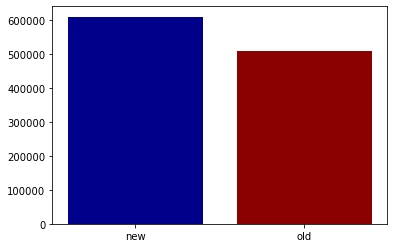

In [12]:
h3 = data[['price','age']].groupby('age').mean().reset_index()
plt.bar( h3['age'], h3['price'], color=['darkblue', 'darkred'] );

# saving graph
fig = plt.gcf()
fig.savefig('comparison.png', format='png')

#### Hipótese 4: Imóveis com 3 banheiros estão ficando mais caros.

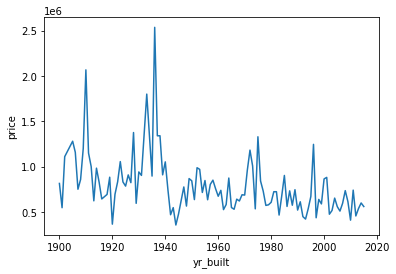

In [13]:
h4 = data.loc[data['bathrooms'] == 3, ['price','yr_built','bathrooms']].groupby('yr_built').mean().reset_index()
sns.lineplot( x='yr_built', y='price', data = h4 );

#### Hipótese 5: Apartamentos são, em média, 20% mais baratos do que casas.

In [14]:
data[['price','dormitory_type']].groupby('dormitory_type').mean().reset_index()

,dormitory_type,price
0,apartment,400925.49
1,house,563609.13
2,studio,323447.27


# 4.0 - CARREGAMENTO